# **Importing Packages**

In [47]:
from scipy.io import wavfile
!pip install audiofile
import audiofile
from scipy.signal import butter, filtfilt, lfilter, find_peaks
from scipy.fft import fft, fftshift
import numpy as np
from IPython.display import Audio
import soundfile as sf
import matplotlib.pyplot as plt

# **Functions**

## **Heart & Lung Sound Signal Separation**

In [48]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')
    return b, a

# ------------------------------------------------------------------------------
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order = order)
  y = lfilter(b, a, data)
  return y

In [49]:
def Heart_Lung_Separation(pcg_signal, fs):
  pcg_filtered = butter_bandpass_filter(pcg_signal, 20, 2000, fs, order=5)
  lung_signal = butter_bandpass_filter(pcg_filtered, 100, 1000, fs, order=5)
  heart_signal = pcg_filtered - lung_signal
  return [heart_signal, lung_signal]

## **Heart Signal Preprocessing**

In [50]:
def heart_signal_preprocessing(heart_signal, fs):
  fc = 100  # Cutoff frequency (Hz)
  # Define the order of the filter (higher order provides better attenuation)
  order = 4
  # Define the normalized cutoff frequency (between 0 and 1, where 1 is the Nyquist frequency)
  w = fc / (fs / 2)
  b, a = butter(order, w, 'low')
  filtered_signal = filtfilt(b, a, heart_signal)
  return filtered_signal

## **Homomorphic Envelope with Hilbert Transform**

In [51]:
from scipy.signal import hilbert

def Homomorphic_Envelope_with_Hilbert(input_signal, fs, lpf_frequency):
  # 8Hz, 1st order, Butterworth LPF
  B_low, A_low = butter(1, 2*lpf_frequency/fs, btype = 'low')
  homomorphic_envelope = np.exp(filtfilt(B_low, A_low, np.log(abs(hilbert(input_signal)))))
  # Remove spurious spikes in first sample:
  homomorphic_envelope[0] = homomorphic_envelope[1]
  return homomorphic_envelope

## **Heart Rate**

In [52]:
def HeartRate(preprocessed_data, fs):
  # Find the homomorphic envelope
  homomorphic_envelope = Homomorphic_Envelope_with_Hilbert(preprocessed_data, fs, 8)
  # Find the autocorrelation:
  y = homomorphic_envelope-np.mean(homomorphic_envelope)
  lags, c = xcorr(y, y, detrend = False, maxlags = len(y)-1)
  signal_autocorrelation = c[len(homomorphic_envelope):]
  min_index = int(0.5*fs)
  max_index = 2*fs
  index = np.argmax(signal_autocorrelation[min_index-1:max_index])
  true_index = index+min_index-1
  heartRate = 60/(true_index/fs)
  return round(heartRate)

## -----------------------------------------------------------------------------
def xcorr(x, y, normed = True, detrend = False, maxlags = 10):
    # Cross correlation of two signals of equal length
    # Returns the coefficients when normed=True
    # Returns inner products when normed=False
    # Usage: lags, c = xcorr(x,y,maxlags=len(x)-1)
    # Optional detrending e.g. mlab.detrend_mean
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')

    if detrend:
        import matplotlib.mlab as mlab
        x = mlab.detrend_mean(np.asarray(x)) # can set your preferences here
        y = mlab.detrend_mean(np.asarray(y))

    c = np.correlate(x, y, mode='full')

    if normed:
        n = np.sqrt(np.dot(x, x) * np.dot(y, y)) # this is the transformation function
        c = np.true_divide(c,n)

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)

    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    return lags, c

## **Lung Signal Preprocessing**

In [53]:
def lung_signal_preprocessing(lung_signal, fs):
    low_cutoff = 200 
    high_cutoff = 1000 
    order=4
    nyquist_freq = 0.5 * fs
    low = low_cutoff / nyquist_freq
    high = high_cutoff / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, lung_signal)
    return filtered_signal

In [44]:
def lung_signal_preprocessing(lung_signal, fs):
  # Define the filter parameters
  cutoff = 250 # Hz  100
  order = 4
  b, a = butter(order, cutoff/(fs/2), btype='highpass')
  filtered_signal = filtfilt(b, a, lung_signal)
  return filtered_signal

## **Respiration Rate**

In [54]:
def Respiration_Rate(preprocessed_data, fs):
    preprocessed_data = (preprocessed_data - np.mean(preprocessed_data)) / np.std(preprocessed_data)
    spike_peaks, values = find_peaks(preprocessed_data, height = 0)
    ind =  [index for index,value in enumerate(preprocessed_data) if abs(value) >= 8*np.mean(values['peak_heights'])]
    preprocessed_data[ind] = np.mean(preprocessed_data)
    peaks, _ = find_peaks(preprocessed_data, height = 3.6, distance = 2*fs)
    if len(peaks) > 7:
        one_breath = 1.5*fs
    else:
        one_breath = 2.7*fs
    peaks, _ = find_peaks(preprocessed_data, height = 3.5, distance = one_breath)
    time = len(preprocessed_data)/fs
    RR = len(peaks)*60/time
    return round(RR)

## **Preprocessing**

In [76]:
def Preprocessing(pcg_signal, fs):
  heart_signal, lung_signal = Heart_Lung_Separation(pcg_signal, fs)
  t = np.linspace(0,20,len(pcg_signal))
  plt.figure(figsize=(7,8))
  plt.subplot(3,1,1)
  plt.plot(t, pcg_signal)
  plt.title('PCG signal')
  plt.subplot(3,1,2)
  plt.plot(t, heart_signal)
  plt.title('Heart signal')
  plt.subplot(3,1,3)
  plt.plot(t, lung_signal)
  plt.title('Lung signal')
  plt.subplots_adjust(hspace=0.5)
  plt.show()
  preprocessed_heart_signal = heart_signal_preprocessing(heart_signal, fs)
  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(t, heart_signal)
  plt.title('Heart signal')
  plt.subplot(2,1,2)
  plt.plot(t, preprocessed_heart_signal)
  plt.title('Preprocessed heart signal')
  plt.subplots_adjust(hspace=0.5)
  plt.show()
  preprocessed_lung_signal = lung_signal_preprocessing(lung_signal, fs)
  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(t, lung_signal)
  plt.title('Lung signal')
  plt.subplot(2,1,2)
  plt.plot(t, preprocessed_lung_signal)
  plt.title('Preprocessed lung signal')
  plt.subplots_adjust(hspace=0.5)
  plt.show()
  return [preprocessed_heart_signal, preprocessed_lung_signal]

# **Implementing ML and Neural Network for signal classification**

## **Heart Sound Signal Classification**
### **Classes:**


*   Normal
*   Murmur



In [10]:
from tensorflow.keras.models import load_model
import numpy as np
import librosa

In [11]:
file_name = 'F:\HEKIDESK\My Codes\Heart_Sound_Classification_Model.h5'
lstm_model = load_model(file_name)

**Prediction**

In [12]:
def Heart_Class_Prediction (signal, fs):
    classes = ["murmur","normal"]
    signal = np.array(np.float32(signal))
    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=52, n_fft=512, hop_length=2048).T,axis=0)
    feature = np.array(mfccs).reshape([-1,1])
    preds = lstm_model.predict(mfccs.reshape(1,52,1))
    confidence = np.amax(preds)
    preds = classes[np.argmax(preds)]
    return preds, confidence

## **Testing a signal:**

In [55]:
# Load the combined heart/lung sound signal into an array
with open('pcg_15.txt') as fid:
    data = fid.readlines()
new_data = list(map(lambda s: s.strip(), data))
new_data.remove('[')
new_data.remove(']')
for i in range(len(new_data)):
    new_data[i] = new_data[i].replace(',', '')
pcg_signal = list(map(int, new_data))
fs = int(np.floor(len(pcg_signal)/10))

Text(0.5, 1.0, 'PCG signal')

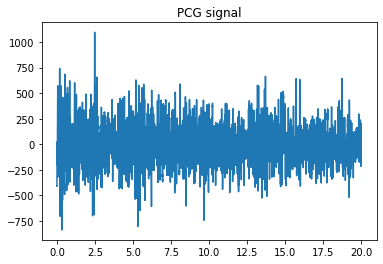

In [56]:
t = np.linspace(0,20,len(pcg_signal))
plt.figure()
plt.plot(t, pcg_signal)
plt.title('PCG signal')

In [57]:
heart_signal, lung_signal = Heart_Lung_Separation(pcg_signal, fs)

Text(0.5, 1.0, 'Heart signal')

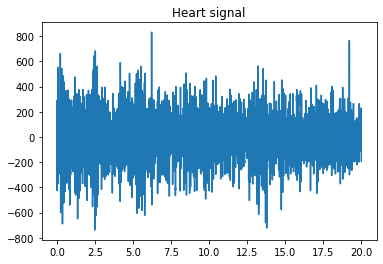

In [58]:
plt.figure()
plt.plot(t, heart_signal)
plt.title('Heart signal')

Text(0.5, 1.0, 'Lung signal')

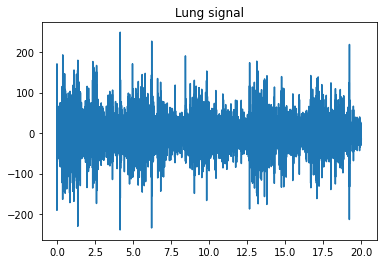

In [59]:
plt.figure()
plt.plot(t, lung_signal)
plt.title('Lung signal')

Text(0.5, 1.0, 'Preprocessed heart signal')

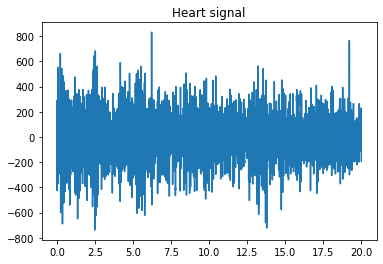

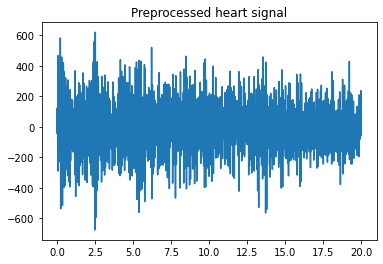

In [60]:
preprocessed_heart_signal = heart_signal_preprocessing(heart_signal, fs)
plt.figure()
plt.plot(t, heart_signal)
plt.title('Heart signal')
plt.figure()
plt.plot(t, preprocessed_heart_signal)
plt.title('Preprocessed heart signal')

Text(0.5, 1.0, 'Preprocessed lung signal')

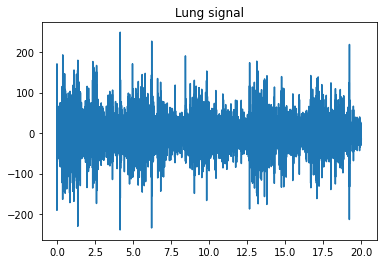

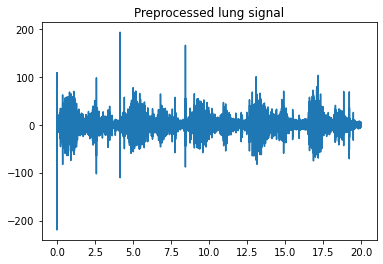

In [61]:
preprocessed_lung_signal = lung_signal_preprocessing(lung_signal, fs)
plt.figure()
plt.plot(t, lung_signal)
plt.title('Lung signal')
plt.figure()
plt.plot(t, preprocessed_lung_signal)
plt.title('Preprocessed lung signal')

**Calculating Heart Rate and Respiration Rate**

In [78]:
heartRate = HeartRate(preprocessed_heart_signal, fs)
print('Heart Rate:', heartRate)
preprocessed_lung_signal = lung_signal_preprocessing(lung_signal, fs)
respirationRate = Respiration_Rate(preprocessed_lung_signal, fs)
print('Respiration Rate:', respirationRate)

Heart Rate: 97
Respiration Rate: 15


**Plotting preprocessed signals:**

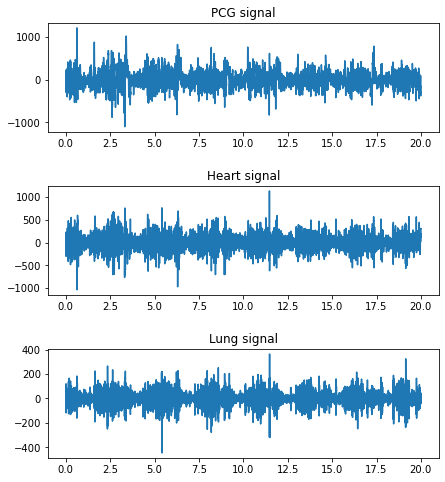

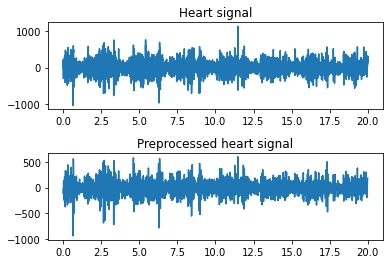

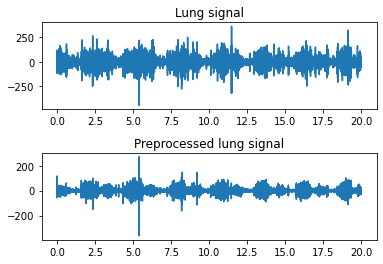

In [79]:
preprocessed_heart_signal, preprocessed_lung_signal = Preprocessing(pcg_signal, fs)

**Determining the class of heart sound**

In [46]:
preds, confidence = Heart_Class_Prediction (preprocessed_heart_signal, fs)
print('The class of heart sound is', preds,'with', confidence,'% confidence.')

1/1 [==============================] - 2s 2s/step
The class of heart sound is murmur with 0.9999964 % confidence.
